# Unconformity or Onlap?
This notebook builds synthetic data to classify well logs based on stratal geometry. Specifically it is focused on classifying a well as either having an angular unconformity or onlapping a structural high. There is plenty of work that can be done going forward to build out the training data with more real world examples

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'theano'


In [92]:
names = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven',
         'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen'] #this creates dummy names for the formations
number_of_layers = 9 #this is the number of tops you want in your training data
neighbors = np.random.randint(1,200) #if we want to include neighbor data in training
df =  pd.DataFrame()

#this section builds some toy data with an angular unconformity
for j in np.arange(3,5.5,0.1):
    rolling = pd.DataFrame()
    rolling['zero'] = 3*np.sin(np.arange(0,20,0.1)/6.28)+np.random.rand(200)/100
    for i in range(len(names[0:number_of_layers])):
        layer_elevation = 3*np.sin(np.arange(0,20,0.1)/6.28)+np.random.uniform(0,j)
        elevation = np.full(200, j)+np.random.rand(200)/100
        layer_elevation = np.where(layer_elevation > elevation, elevation, layer_elevation)+np.random.rand(200)/100
        rolling[names[i]] = layer_elevation
#this loop creates 0 values at random in the data much like you would see in an incomplete tops dataset
#the range value is the number of entries to set to zero
    for k in range(1500):
        rolling.iloc[np.random.randint(0,199), np.random.randint(0,number_of_layers-1)] = 0
    df = pd.concat((df, rolling))
angular_thicknesses = df.T.diff(axis=0).abs().T #calculate formation thicknesses
#neigh = angular_thicknesses.shift(neighbors)
logged = angular_thicknesses.apply(np.log) #take the log of thicknesses for feature engineering
powered= angular_thicknesses.apply(lambda x: x**10) #calculates the power values of thickness for another feature
angular_thicknesses = pd.concat([angular_thicknesses, logged, powered], axis=1, join_axes=[angular_thicknesses.index]
                        ).drop(columns=['zero']).dropna().replace(-np.inf, 0) #dataframe of angular unconformity fm thicknesses

#now for onlap training data construction
df_onlap =  pd.DataFrame()
    
for j in np.arange(3,5.5,0.1):
    rolling = pd.DataFrame()
    rolling['zero'] = 3*np.sin(np.arange(0,20,0.1)/6.28)
    for i in range(len(names[0:number_of_layers])):
        zero = 3*np.sin(np.arange(0,20,0.1)/6.28)+np.random.rand(200)/100
        randomness = np.random.uniform(0,j)
        elevation = np.full(200, j)+np.random.rand(200)/100
        onlap = np.where(np.full(200,randomness) > zero, np.full(200,randomness)+np.random.rand(200)/100, zero)
        layer_elevation = np.where( onlap > elevation, elevation,  onlap)
        rolling[names[i]] = layer_elevation
#this loop creates 0 values at random in the data much like you would see in an incomplete tops dataset
#the range value is the number of entries to set to zero

    for k in range(1500):
        rolling.iloc[np.random.randint(0,199), np.random.randint(0,number_of_layers-1)] = 0
    df_onlap = pd.concat((df_onlap, rolling))
onlap_thicknesses = df_onlap.T.diff(axis=0).abs().T
#neigh = onlap_thicknesses.shift(neighbors)
logged = onlap_thicknesses.apply(np.log)
powered= onlap_thicknesses.apply(lambda x: x**10)
onlap_thicknesses = pd.concat([onlap_thicknesses, logged, powered], axis=1, join_axes=[onlap_thicknesses.index]
                               ).drop(columns=['zero']).dropna().replace(-np.inf, 0)

#if you want to create a section with horizontal stratified training data this section will do it

df_horizontal =  pd.DataFrame()
    
for j in np.arange(3, 5.5,0.1):
    rolling = pd.DataFrame()
    rolling['zero'] = np.full(200, 0)-np.random.rand(200)/100
    for i in range(len(names[0:number_of_layers])):
        randomness = np.random.uniform(0,j)
        elevation = np.full(200, j)+np.random.rand(200)/100
        horiz = np.full(200,randomness)
        layer_elevation = np.where( horiz > elevation, elevation,  horiz)
        rolling[names[i]] = layer_elevation
    for k in range(1500):
        rolling.iloc[np.random.randint(0,199), np.random.randint(0,number_of_layers-1)] = 0
    df_horizontal = pd.concat((df_horizontal, rolling))
horizontal_thicknesses = df_horizontal.T.diff(axis=0).abs().T
#neigh = horizontal_thicknesses.shift(neighbors)
logged = horizontal_thicknesses.apply(np.log)
powered= horizontal_thicknesses.apply(lambda x: x**10)

horizontal_thicknesses = pd.concat([horizontal_thicknesses, logged, powered], axis=1, join_axes=[horizontal_thicknesses.index]
                               ).drop(columns=['zero']).dropna().replace(-np.inf, 0)

#normalize the data from 0 to 1
normalized_df=(angular_thicknesses-angular_thicknesses.min())/(angular_thicknesses.max()-angular_thicknesses.min()
                                                              ).replace(0,0.00001)
normalized_dfo=(onlap_thicknesses-onlap_thicknesses.min())/(onlap_thicknesses.max()-onlap_thicknesses.min()).replace(0,0.00001)
normalized_dfh=(horizontal_thicknesses-horizontal_thicknesses.min())/(horizontal_thicknesses.max()-horizontal_thicknesses.min()
                                                                     ).replace(0,0.00001)
#now assign classes to the datasets, 1 is onlap, 0 is angular unconformity
normalized_dfo['class'] = 1
normalized_df['class'] = 0
#normalized_dfh['class'] = 2

#merge into new dataset
dataset = pd.concat((normalized_df, normalized_dfo))


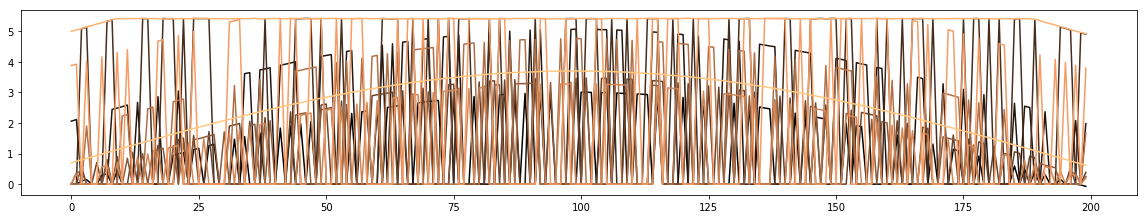

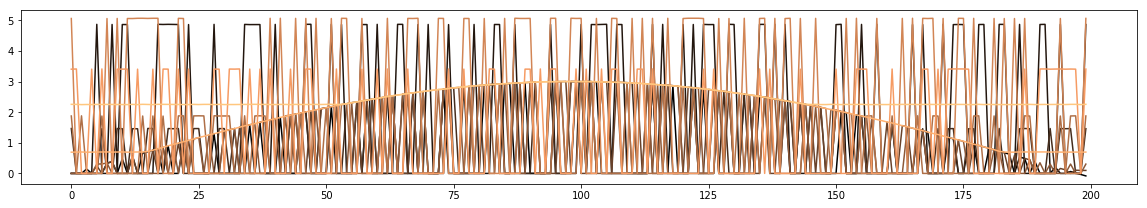

In [93]:
#now let's visualize what the stratigraphy looks like for our toy training data
df.iloc[-200:].plot(legend=False, figsize=(20,10), cmap='copper').set_aspect(6)
df_onlap.iloc[-200:].plot(legend=False, figsize=(20,10), cmap='copper').set_aspect(6)
#df_horizontal.iloc[1200:1400].plot(legend=False, figsize=(20,10), cmap='copper').set_aspect(6)

In [94]:
from sklearn.model_selection import train_test_split
#next let's split our toy data into training and test sets, choose how much with test_size of the data becomes the test set
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[0:, 0:-1].values, dataset.iloc[0:,-1].values, 
                                                    test_size=0.5, random_state=86)

In [95]:
from keras.utils import to_categorical
y_train_encoded = to_categorical(y_train) #this converts the target variable to one-hot encoding
y_test_encoded = to_categorical(y_test) #same with the test data conversion to one-hot encoding

In [96]:
#Import keras and some layers, we are going to build a network with two dense layers and a dropout layer
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [97]:
#this is the network, we initialize with a dense layer and a relu activation
model = Sequential()
model.add(Dense(100, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5)) #dropout to avoid overfitting
model.add(Dense(2, kernel_initializer='random_uniform', activation='sigmoid')) #and another dense layer with sigmoid activation

In [98]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['binary_accuracy']) 
#builds the model, with categorical crossentropy for our loss function, optimizing using nadam, and using categorical accuracy
#as our accuracy metric

In [99]:
model.fit(X_train, y_train_encoded, epochs=600, batch_size=32) #Fitting the model for 60 epochs and batch size of 32

Epoch 1/600
5000/5000 [==============================] - 1s 137us/step - loss: 0.6793 - binary_accuracy: 0.5688
Epoch 2/600
5000/5000 [==============================] - 0s 37us/step - loss: 0.6592 - binary_accuracy: 0.5970
Epoch 3/600
5000/5000 [==============================] - 0s 37us/step - loss: 0.6489 - binary_accuracy: 0.6099
Epoch 4/600
5000/5000 [==============================] - 0s 36us/step - loss: 0.6421 - binary_accuracy: 0.6237
Epoch 5/600
5000/5000 [==============================] - 0s 37us/step - loss: 0.6288 - binary_accuracy: 0.6500
Epoch 6/600
5000/5000 [==============================] - 0s 38us/step - loss: 0.6187 - binary_accuracy: 0.6498
Epoch 7/600
5000/5000 [==============================] - 0s 37us/step - loss: 0.6127 - binary_accuracy: 0.6554
Epoch 8/600
5000/5000 [==============================] - 0s 36us/step - loss: 0.5965 - binary_accuracy: 0.6757
Epoch 9/600
5000/5000 [==============================] - 0s 37us/step - loss: 0.5933 - binary_accuracy: 0.6733


In [100]:
score=model.evaluate(X_test, y_test_encoded) #tests the model on the test data
score

5000/5000 [==============================] - 0s 63us/step


[0.0708288370758295, 0.9812]

In [101]:
model.save('.\onlap_model.h5')

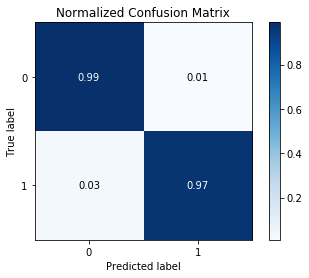

In [102]:
preds = model.predict(X_test) #creates predictions on the test data that we can use
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, np.argmax(preds, axis=1), normalize=True) #let's visualize the predictions

In [103]:
from keras.models import load_model
model2 = load_model('onlap_model.h5')
preds2 = model2.predict(X_test)


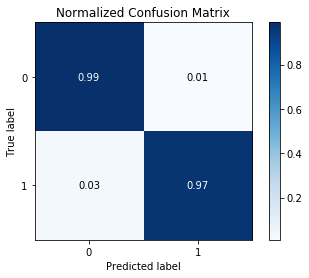

In [104]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, np.argmax(preds2, axis=1), normalize=True) #let's visualize the predictions


In [105]:
#let's import some real world data from southwestern Wyoming
#this is from the Rock Springs Uplift in Wyoming and has been interpreted as an angular unconformity
tops = pd.read_csv(r'D:\jupyter\Early WSGS\ftunion.csv').fillna(0) #this file is available in the unconformity or onlap folder in the repo
tops.head()

,API,Tfu,Tfob,Tfb,Tfc,Klr,Kl,Kll,Klz,Kfh
0,4900705010,0.0,0.0,0.0,0.0,2294.3,2294.3,2569.6,3085.4,3917.7
1,4900705018,973.9,1226.3,1295.5,1569.4,2310.3,2310.3,2696.6,3289.7,3800.6
2,4900705023,1891.7,2257.6,2368.2,2506.6,3307.5,3307.5,3945.5,0.0,4860.1
3,4900705050,2287.6,2681.5,2732.2,2923.5,3652.1,3652.1,4125.9,4494.2,5340.9
4,4900705051,741.0,1275.6,1326.3,1478.2,2243.6,2243.6,2738.6,3340.8,4246.8


In [106]:
#clean up the real world data, take the tops from depth to thickness for each formation and get rid of negative thicknesses
tops2 = tops[tops.columns[1:]].T.diff().T
tops2[tops2 < 0] =0
tops2.head()

,Tfu,Tfob,Tfb,Tfc,Klr,Kl,Kll,Klz,Kfh
0,NaN,0.0,0.0,0.0,2294.3,0.0,275.3,515.8,832.3
1,NaN,252.4,69.2,273.9,740.9,0.0,386.3,593.1,510.9
2,NaN,365.9,110.6,138.4,800.9,0.0,638.0,0.0,4860.1
3,NaN,393.9,50.7,191.3,728.6,0.0,473.8,368.3,846.7
4,NaN,534.6,50.7,151.9,765.4,0.0,495.0,602.2,906.0


In [107]:
#neigh = tops2.shift(1)
logged = tops2.apply(np.log) #creating the same features that we built in the training data
powered= tops2.apply(lambda x: x**10) #creating the same features that we built in the training data
tops3 = pd.concat([tops2, logged, powered], axis=1, join_axes=[tops2.index]
                               ).fillna(0).replace(-np.inf, 0)

In [108]:
normalized_tops3=(tops3-tops3.min())/(tops3.max()-tops3.min()).replace(0,0.00001) #normalize the data from 0 to 1
real_data = normalized_tops3.values

In [109]:
well_preds = model.predict(real_data) #make some predictions

In [110]:
predictions = np.argmax(well_preds, axis=1) #convert them to our binary classification

(array([833.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  55.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

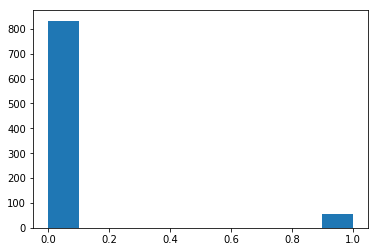

In [120]:
plt.hist(predictions, label = ['Angular Unconformity', 'Onlap']) #visualize the predictions as a histogram, we are expecting all the wells to be classified as '0'


In [112]:
print('Accuracy on the real world data is '+str(100*(len(predictions)-np.sum(predictions))/len(predictions))+'%')

Accuracy on the real world data is 93.80630630630631%
